
### <div align="center"> Emotion Classification on text using Natural Language Processing (NLP) </div>

### Library Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

### Importing Data

In [2]:
train_df = pd.read_csv('train.txt', names=['text', 'emotion'], sep=';')
test_df = pd.read_csv('test.txt', names=['text', 'emotion'], sep=';')
val_df = pd.read_csv('val.txt', names=['text', 'emotion'], sep=';')

In [3]:
train_df.shape

(16000, 2)

In [4]:
train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
test_df.head()

,text,emotion
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness


In [6]:
val_df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


### EDA (Exploratory Data Analysis)

Emotions

<Axes: xlabel='emotion', ylabel='count'>

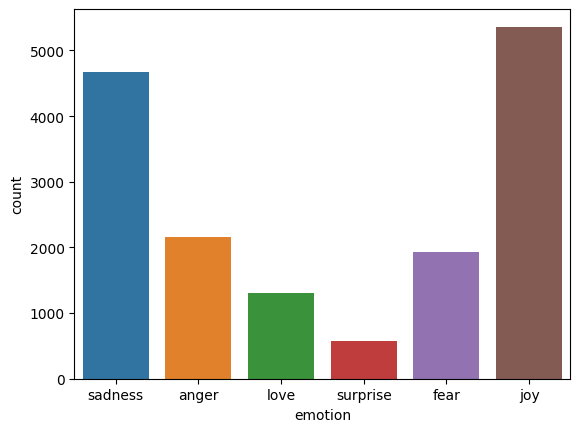

In [7]:
sns.countplot(data=train_df, x = "emotion")

<Axes: xlabel='emotion', ylabel='count'>

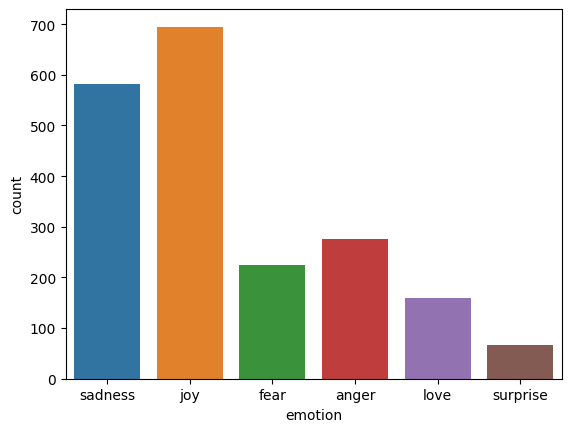

In [8]:
sns.countplot(data=test_df, x = "emotion")

Kesimpulan : adanya ketidakseimbangan dalam label

Akan dilakukan downscaling untuk menyeimbangkan data

In [9]:
class_counts = train_df['emotion'].value_counts()
min_count = class_counts.min()

In [10]:
test_class_counts = test_df['emotion'].value_counts()
test_min_count = test_class_counts.min()

In [11]:
val_class_counts = val_df['emotion'].value_counts()
val_min_count = val_class_counts.min()

In [12]:
downsampled_data = pd.DataFrame()
for emotion, count in class_counts.items():
    if count > min_count or emotion == 'surprise':
        # If the class has more instances than min_count or it is 'surprise', include all 'surprise' instances
        if emotion == 'surprise':
            downsampled_data = pd.concat([downsampled_data, train_df[train_df['emotion'] == emotion]])
        else:
            downsampled_data = pd.concat([downsampled_data, train_df[train_df['emotion'] == emotion].sample(min_count)])

downsampled_data = downsampled_data.reset_index(drop=True)

In [13]:
test_downsampled_data = pd.DataFrame()
for emotion, count in test_class_counts.items():
    if count > test_min_count or emotion == 'surprise':
        # If the class has more instances than min_count or it is 'surprise', include all 'surprise' instances
        if emotion == 'surprise':
            test_downsampled_data = pd.concat([test_downsampled_data, test_df[test_df['emotion'] == emotion]])
        else:
            test_downsampled_data = pd.concat([test_downsampled_data, test_df[test_df['emotion'] == emotion].sample(test_min_count)])

test_downsampled_data = test_downsampled_data.reset_index(drop=True)

In [14]:
val_downsampled_data = pd.DataFrame()
for emotion, count in val_class_counts.items():
    if count > val_min_count or emotion == 'surprise':
        # If the class has more instances than min_count or it is 'surprise', include all 'surprise' instances
        if emotion == 'surprise':
            val_downsampled_data = pd.concat([val_downsampled_data, val_df[val_df['emotion'] == emotion]])
        else:
            val_downsampled_data = pd.concat([val_downsampled_data, val_df[val_df['emotion'] == emotion].sample(val_min_count)])

val_downsampled_data = val_downsampled_data.reset_index(drop=True)

In [15]:
train_df = downsampled_data.copy()

In [16]:
test_df = test_downsampled_data.copy()

In [19]:
val_df = val_downsampled_data.copy()

<Axes: xlabel='emotion', ylabel='count'>

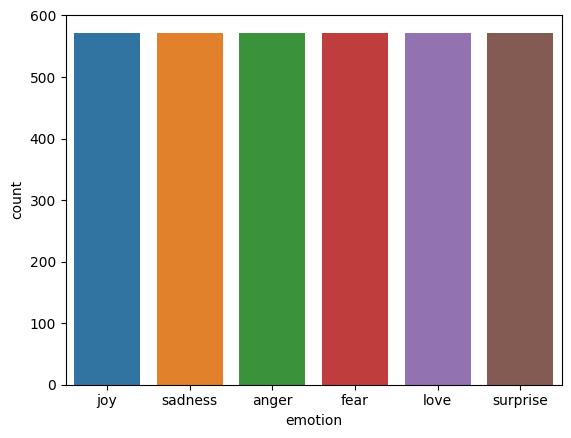

In [18]:
sns.countplot(data=train_df, x = "emotion")

<Axes: xlabel='emotion', ylabel='count'>

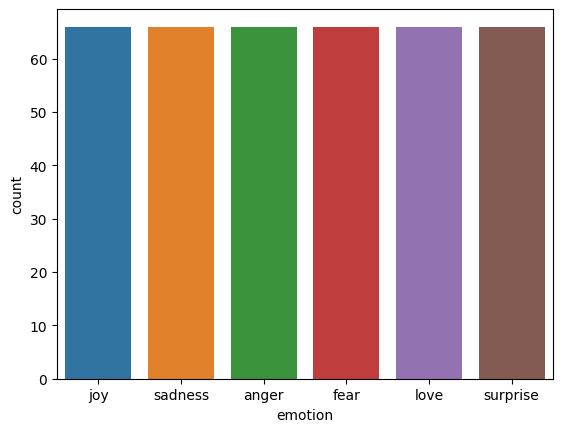

In [20]:
sns.countplot(data=test_df, x = "emotion")

<Axes: xlabel='emotion', ylabel='count'>

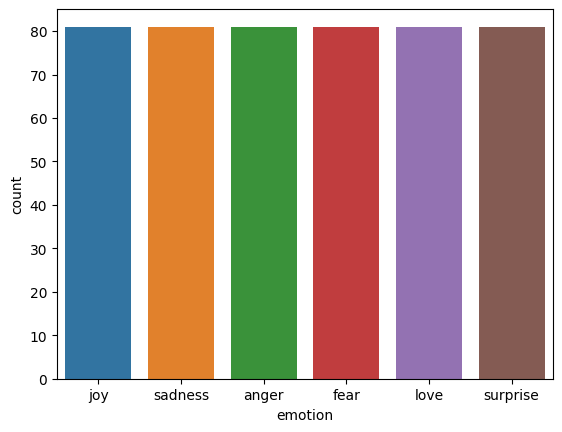

In [21]:
sns.countplot(data=val_df, x = "emotion")

In [22]:
train_df.shape

(3432, 2)

In [23]:
val_df.shape

(486, 2)

In [24]:
test_df.shape

(396, 2)

Statistics about length of text

In [25]:
train_df['text_length'] = train_df['text'].apply(len)

In [26]:
summary = train_df['text_length'].describe()
summary

count    3432.000000
mean       97.394231
std        55.480513
min         7.000000
25%        54.000000
50%        86.500000
75%       130.000000
max       298.000000
Name: text_length, dtype: float64

<Axes: xlabel='text_length'>

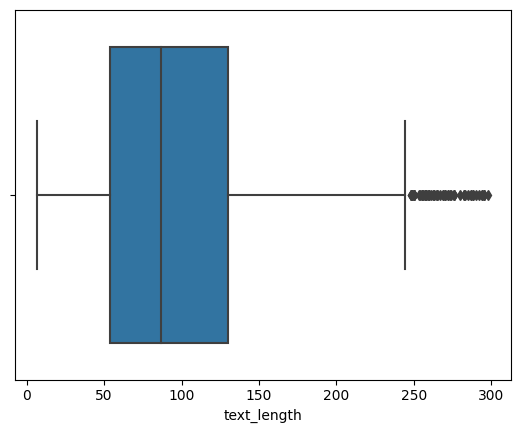

In [27]:
sns.boxplot(data=train_df, x = "text_length")

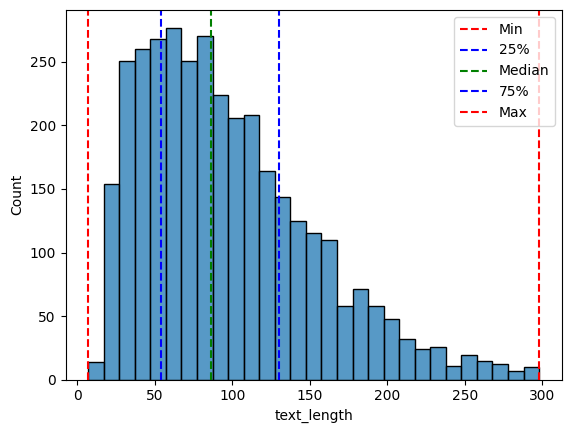

In [28]:
sns.histplot(data=train_df, x='text_length')
plt.axvline(summary['min'], color='r', linestyle='--', label='Min')
plt.axvline(summary['25%'], color='b', linestyle='--', label='25%')
plt.axvline(summary['50%'], color='g', linestyle='--', label='Median')
plt.axvline(summary['75%'], color='b', linestyle='--', label='75%')
plt.axvline(summary['max'], color='r', linestyle='--', label='Max')
plt.legend();

### Column Encoding

In [29]:
le = LabelEncoder()
train_df['emotion'] = le.fit_transform(train_df['emotion'])
val_df['emotion'] = le.transform(val_df['emotion'])

In [30]:
train_df.head()

,text,emotion,text_length
0,im feeling pretty energetic,2,27
1,im feeling the moxie fab love cath script src ...,2,54
2,i love to inspire students to be creative and ...,2,134
3,went to a movie with a date,2,27
4,i feel so honoured so have been allowed to wri...,2,61


In [31]:
val_df.head()

,text,emotion
0,i am at day and i am feeling terrific,2
1,i love this song and it always makes me feel h...,2
2,i did see a few people looking at the points a...,2
3,im feeling terrific and in great shape im opti...,2
4,i know how much work goes into the creation an...,2


In [32]:
test_df.head()

,text,emotion
0,i thought maybe once i started running i would...,joy
1,i litsen to his music i feel so much pride to ...,joy
2,i like the fresh feeling of sweet he gave me,joy
3,i feel is vital to keeping my spirit young eve...,joy
4,i love the fact that i look as best i can and ...,joy


### Emotion Dataset (Data Encoding)

In [33]:
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = str(self.df.loc[index, 'text'])
        emotion = self.df.loc[index, 'emotion']

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emotion': torch.tensor(emotion, dtype=torch.long)
        }

### Tokenizer

In [34]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [35]:
#setting parameters
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16

train_dataset = EmotionDataset(train_df, tokenizer, MAX_LEN)
val_dataset = EmotionDataset(val_df, tokenizer, MAX_LEN)

train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)

## Creating Model

In [36]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertSentimentClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout()
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.dropout2(output)
        logits = self.fc2(output)

        return logits

In [37]:
bert_model_name = "bert-base-uncased"
num_classes = train_df["emotion"].nunique()
model = BertSentimentClassifier(bert_model_name, num_classes)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Untuk membuat pytorch model untuk sentiment classification, nerural network dibuat dari input sampai output plus dropout layer

In [38]:
criterion = nn.CrossEntropyLoss()

## Training

In [39]:
def train(model, data_loader, optimizer, criterion, device):
    # set the model to train mode
    model.train()

    # initialize the loss and accuracy
    total_loss, total_accuracy = 0, 0

    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)

        # zero the gradient
        optimizer.zero_grad()

        # get the model's predictions
        outputs = model(input_ids, attention_mask)

        # get the loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # accuracy calculation
        logits = outputs.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        total_accuracy += flat_accuracy(logits, label_ids)

        # perform backpropagation and optimization
        loss.backward()
        optimizer.step()

    # calculate the average loss
    avg_loss = total_loss / len(data_loader)
    avg_acc = total_accuracy / len(data_loader)


    return avg_loss, avg_acc

In [40]:
def evaluate(model, data_loader, criterion, device):
    # set the model to eval mode
    model.eval()

    # initialize the loss and accuracy variables
    total_loss = 0
    total_accuracy = 0

    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)

        # disable gradient computation
        with torch.no_grad():
            # get the model's predictions
            outputs = model(input_ids, attention_mask)

            # get the loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # calculate the number of correct predictions
            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            total_accuracy += flat_accuracy(logits, label_ids)

    # calculate the average loss and accuracy
    avg_loss = total_loss / len(data_loader)
    accuracy = total_accuracy / len(data_loader)

    return avg_loss, accuracy

In [41]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Tuning hyperparameter: Grid Search

In [45]:
from sklearn.model_selection import ParameterGrid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define the grid of hyperparameters
param_grid = {
    'lr': [1e-5, 2e-5, 3e-5],  # Different learning rates to try
    'weight_decay': [0.01, 0.001, 0.0001]  # Different weight decay values to try
}
num_epochs = 15


train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

# Generate all combinations of hyperparameters
grid = ParameterGrid(param_grid)

best_val_accuracy = 0.0
best_hyperparameters = None

# Iterate over each combination of hyperparameters
for params in grid:
    # Create a new model with the specified hyperparameters
    model = BertSentimentClassifier(bert_model_name, num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    model.to(device)

    # Train the model with the current hyperparameters
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
        # ...

    # Evaluate the model on the validation set
    # Save the best hyperparameters based on validation accuracy
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_hyperparameters = params

print("Best hyperparameters:", best_hyperparameters)
print("Best validation accuracy:", best_val_accuracy)


100%|██████████| 31/31 [00:03<00:00,  7.98it/s]

Best hyperparameters: {'lr': 2e-05, 'weight_decay': 0.01}
Best validation accuracy: 0.9133064516129032


Training with best parameters

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 2e-5
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)

# Move the model to the device
model.to(device)

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Define early stopping parameters
patience = 2  # Number of epochs to wait for improvement
best_val_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}')

    # Train the model
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)

    # Evaluate the model on the validation set
    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

    # Save the model if validation accuracy improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pt')  # Save the best model weights

    # Early stopping
    if epoch - best_epoch >= patience:
        print(f'Early stopping at epoch {epoch + 1} as there is no improvement for {patience} epochs.')
        break  # End training loop

    # Save metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch 1


100%|██████████| 31/31 [00:03<00:00,  8.20it/s]


Train Loss: 1.6331 | Train Acc: 0.2765 | Val Loss: 1.2115 | Val Acc: 0.5901
Epoch 2


100%|██████████| 31/31 [00:03<00:00,  8.01it/s]


Train Loss: 0.7313 | Train Acc: 0.7672 | Val Loss: 0.4231 | Val Acc: 0.8737
Epoch 3


100%|██████████| 31/31 [00:03<00:00,  7.83it/s]


Train Loss: 0.3047 | Train Acc: 0.9122 | Val Loss: 0.2657 | Val Acc: 0.9254
Epoch 4


100%|██████████| 31/31 [00:04<00:00,  7.69it/s]


Train Loss: 0.2053 | Train Acc: 0.9419 | Val Loss: 0.2688 | Val Acc: 0.9153
Epoch 5


100%|██████████| 31/31 [00:03<00:00,  7.93it/s]


Train Loss: 0.1784 | Train Acc: 0.9462 | Val Loss: 0.3161 | Val Acc: 0.8918
Epoch 6


100%|██████████| 31/31 [00:03<00:00,  7.98it/s]

Train Loss: 0.1604 | Train Acc: 0.9459 | Val Loss: 0.2550 | Val Acc: 0.9173
Early stopping at epoch 6 as there is no improvement for 2 epochs.


In [43]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Plot the training loss curve
    ax[0].plot(train_losses, label='Training Loss')
    ax[0].plot(val_losses, label='Validation Loss')

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training and Validation Loss')
    ax[0].legend()

    # Plot the training accuracy curve
    ax[1].plot(train_accuracies, label='Training Accuracy')
    ax[1].plot(val_accuracies, label='Validation Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Training and Validation Accuracy')

    plt.show()

In [49]:
input_text = test_df.sample(n=7).text.values[0]
input_text

'i can t help feeling curious about it'

### Testing

In [50]:
encoded_input = tokenizer.encode_plus(
    input_text,
    add_special_tokens = True,
    truncation = True,
    max_length = MAX_LEN,
    return_token_type_ids = False,
    padding = 'max_length',
    return_attention_mask = True,
    return_tensors  = 'pt',
).to(device)

In [51]:
emotion_id = torch.argmax(model(**encoded_input), dim = 1).item()

In [52]:
le.inverse_transform([emotion_id])

array(['surprise'], dtype=object)

### Plotting Accuracy and Loss

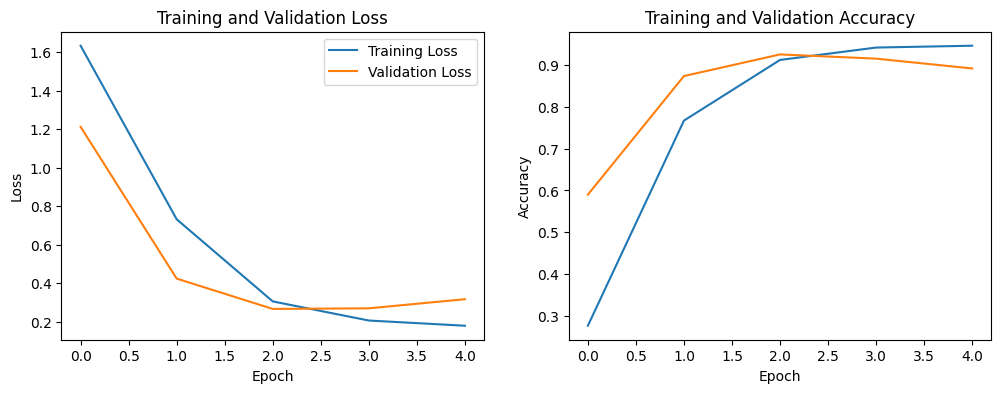

In [53]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

### Evaluation

100%|██████████| 31/31 [00:04<00:00,  7.62it/s]


Overall Accuracy: 0.9156
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91        81
           1       0.90      0.85      0.87        81
           2       0.92      0.89      0.91        81
           3       0.96      0.91      0.94        81
           4       0.88      0.93      0.90        81
           5       0.93      0.99      0.96        81

    accuracy                           0.92       486
   macro avg       0.92      0.92      0.92       486
weighted avg       0.92      0.92      0.92       486



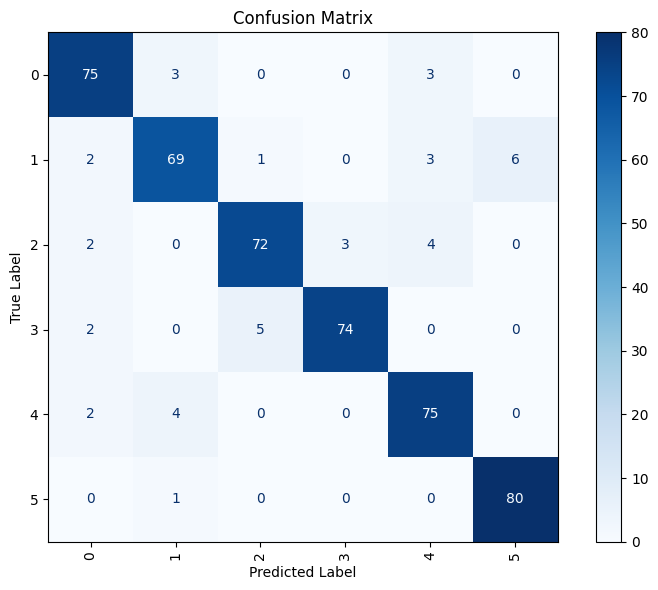

In [72]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def evaluate_with_confusion_matrix(model, data_loader, criterion, device):
    # set the model to eval mode
    model.eval()

    # initialize the lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # iterate over the data loader
    for data in tqdm(data_loader):
        # move the inputs to the device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)

        # disable gradient computation
        with torch.no_grad():
            # get the model's predictions
            outputs = model(input_ids, attention_mask)
            predicted = torch.argmax(outputs, dim=1)

            # collect true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    return cm, true_labels, predicted_labels  # Return confusion matrix along with true and predicted labels

# Evaluate the model and get confusion matrix
conf_matrix, true_labels, predicted_labels = evaluate_with_confusion_matrix(model, val_dataloader, criterion, device)  # Use val_dataloader or test_dataloader as needed

# Calculate overall accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f'Overall Accuracy: {accuracy:.4f}')

# Convert le.classes_ to a list of strings
target_names = le.inverse_transform(np.unique(true_labels))

# Convert target_names to a list of strings
target_names = target_names.astype(str).tolist()

# Compute precision, recall, and F1-score for each class
report = classification_report(true_labels, predicted_labels, target_names=target_names)
print("Classification Report:\n", report)

# Visualize confusion matrix with reverted labels
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=target_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(len(target_names)), target_names)
plt.yticks(np.arange(len(target_names)), target_names)
plt.tight_layout()
plt.show()